 Garrigues Mathieu - Grandjean Valentin




# Rapport : Projet QAP

## Les instances Taixxa

Les instances de Taillard a sont des jeux de données de problèmes d'affectation quadratique.


Ces jeux de données ont été générés aléatoirement par Eric Taillard en 1991. 


Pour les tai15a, tai17a, tai20a, tai25a ont été résolu. C'est à dire que l'on connais la solution optimale.

Pour la définition d'un problème d'affectation quadratique nous avons besoin de 3 choses : 


>- Le nombre n d'emplacement et d'équipements à placer.
>
>
>- Une matrice W représentant les poids (où flux) entre les différent équipement
>
>
>- Une D matrice représentant les distances entre les emplacements

Le but du problème d'affectation quadratique est de positionner n équipements sur n emplacements (trouver X un vecteur de taille n) de manière à réduire le coût suivant 
\\( C = Tr(WXDX^{T})\\)
    
Dans les fichiers Taixxa on retrouve ces élément dans l'ordre précédemment énoncé.

## Les voisinages


### Définition des voisinages

Pour le problème d'affectation quadratique la solution que nous manipulons est un vecteur de taille n (nombre d'emplacement).

Donc nous avons choisi comme voisinage d'un vecteur quelquonque tout les autre vecteurs que l'on peut obtenir en faisant une permutation de deux éléments de ce vecteur.

Exemple : 

\\[ x =\begin{pmatrix}
1\\
2\\
3
\end{pmatrix}
\\]


###### alors


\\[ V(x) = \begin{pmatrix}
a_{1} & a_{2} & a_{3}
\end{pmatrix}
\\]


###### avec


\\[a_{1} = \begin{pmatrix}
2\\
1\\
3
\end{pmatrix}
\\]


\\[a_{2} = \begin{pmatrix}
3\\
2\\
1
\end{pmatrix}
\\]



\\[a_{3} = \begin{pmatrix}
1\\
3\\
2
\end{pmatrix}
\\]



### Justification des voisinages

Ce choix nous parait etre une manière assez équilibré de choisir des voisinages.

Nous nous sommes basés sur plusieurs critères :
- Le nombre de voisin de chaque solution doit être petit pour ne pas avoir des temps de calculs trop long.
- Le nombre de voisin de chaque solution assez grand pour permettre de converger rapidement.
- Le voisinage doit permettre de retrouver n'importe quel solution ou plus mathématiquement : \\( \forall x\in S,\exists y\in S, V(y) = x \\)
- L'opération élémentaire doit etre facilement implémentable pour la méthode Tabou

Imports pour le bon fonctionnement du code

In [1]:
import time

import numpy as np
import random as rd
import pandas as pd
import matplotlib.pyplot as plt
import sys
sys.path.insert(0, '../src/model/')
sys.path.insert(1, '../src/view/')
from Taixxa import Taixxa
from FitnessViewer import FitnessViewer
from FitnessComparator import FitnessComparator
from Permutation import Permutation 
from SimulatedAnnealing import SimulatedAnnealing
from TabuSearch import TabuSearch
from Genetic import GeneticAlgorithm

## Les algorithmes



# Algorithme de recuit simulé

#### Principe et implémentation

Le principe de l'algorithme de recuit simulé est de simuler la méthode de recuit de la métallurgie qui consiste à chauffer puis refroidir lentement le matériau pour réduire les défauts.


Adapté à l'optimisation cette méthode permet d'échapper aux extremum locaux en utilisant une température permettant à l'algorithme d'explorer le landscape du problème.

Nous avons choisi dans notre implémentation de passer en paramètre la fonction qui fait varier la température de manière à regarder le comportement de l'algorithme avec différentes approches.


Les paramètres qui rentre en jeu dans cet algorithme sont :
    
   - n1 : Le nombre de changement de la température
   - n2 : Le nombre d'étapes avec une même température
   - f : La fonction de variation de température ( prend en argument la température initiale et le nombre de changements) 
   - t0 : la température initiale
   
Ce qui nous donne le prototype suivant:
                                                    
    SimulatedAnnealing.solve(t0,n1,n2,f)
    
Cette fonction renvoie la solution trouvée par la méthode ainsi que deux listes, la première contient l'évolution de la fonction de coût pendant la méthode et l'autre  contient l'évolution de la température pendant celle-ci.
    

Définition de quelques fonction qui vont définir comment va varier la température pour l'algorithme de recuit simulé : 


>\\( f_{\exp\sin} \\) est une fonction sinusoidale pondérée par une exponentielle négative (cf premier graphe)
>
>
>\\( f_{\sin} \\) est une fonction sinusoidale simple (cf second graphe)
>
>
>\\( f_{\exp} \\) est une fonction exponentielle négative simple (cf troisième graphe)
>
>
>\\( f_{expreb} \\) est une fonction exponentielle qui revient à la température initiale par paliers (cf quatrième graphe)

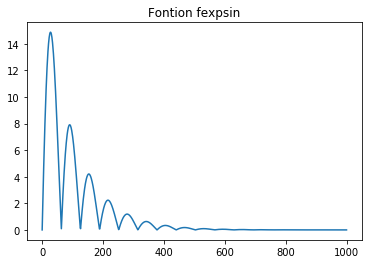

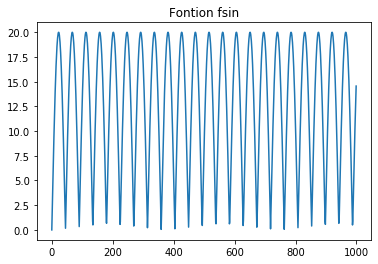

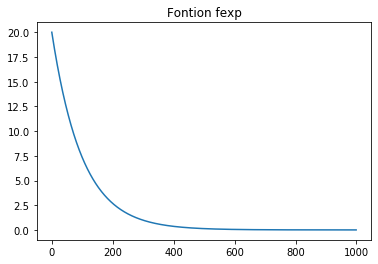

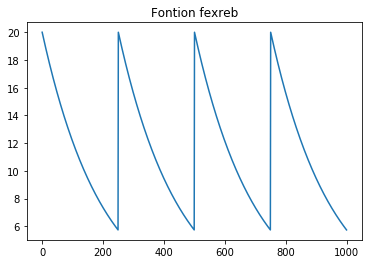

In [2]:
def fexpsin(t,i):
    return t*(0.99**i)*np.abs((np.sin(float(i)*0.05)))
def fsin(t,i):
    return t*np.abs(np.sin(float(i)*0.07))
def fexp(t,i):
    return t*(0.99**i)
def fexpreb(t,i):
    return t*(0.995**(i%250))
t = 20
x = range(1000)
y1 = [fexpsin(t,a) for a in x]
y2 = [fsin(t,a) for a in x]
y3 = [fexp(t,a) for a in x]
y4 = [fexpreb(t,a) for a in x]
viewer = FitnessViewer(np.array(y1))
viewer.plot('Fontion fexpsin')
viewer = FitnessViewer(np.array(y2))
viewer.plot('Fontion fsin')
viewer = FitnessViewer(np.array(y3))
viewer.plot('Fontion fexp')
viewer = FitnessViewer(np.array(y4))
viewer.plot('Fontion fexreb')


#### Choix des paramètres

Pour choisir les paramètres nous allons tester empiriquement l'influence de ces paramètres sur les résultats.
Nous sommes conscient qu'un seul test ne constitue pas une bonne manière d'aborder le problème car la méthode est non-déterministe mais avec une nombre important de test il est possible de distinguer des règles générales.

In [3]:
data = Taixxa()
data.loadFile("tai12a.dat")
siman = SimulatedAnnealing(data)

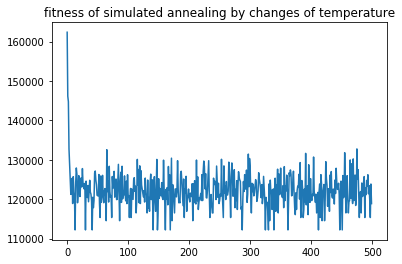

In [19]:
costs = []
for i in range(500):
    sol, fit, temp = siman.solve(55,0,i,75,fexp)
    costs.append(sol.computeCost(data))
    
viewer = FitnessViewer(np.array(costs))
viewer.plot('fitness of simulated annealing by changes of temperature')

##### Choix de n1:

Pour n1 il est clair que le nombre de changements de température  doit etre suppérieur à environ 30 ce qui est en accord avec la théorie car avec une température trop forte l'algorithme aura peut de chance de converger.

A noter que les différentes variations de températures peuvent grandement influencer ce resultat (surtout pour de plus grands jeux de données.

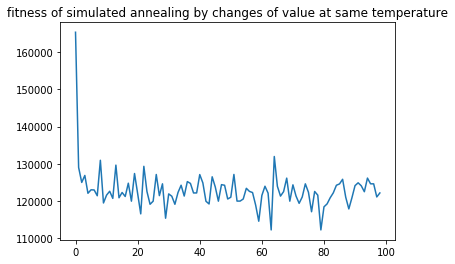

In [20]:
costs = []
for i in range(1,100):
    sol, fit, temp = siman.solve(55,0,75,i,fexp)
    costs.append(sol.computeCost(data))
    
viewer = FitnessViewer(np.array(costs))
viewer.plot('fitness of simulated annealing by changes of value at same temperature')

##### Choix de n2:

Pour n2 il est clair que le nombre de changements à la même température  doit etre suppérieur à environ 15 ce qui est en accord avec la théorie car avec peu de changements l'algorithme n'explore pas assez les possibles.

../src/model\SimulatedAnnealing.py:42: RuntimeWarning: divide by zero encountered in long_scalars
  if p <= np.exp(-variationF / temp):
../src/model\SimulatedAnnealing.py:42: RuntimeWarning: divide by zero encountered in true_divide
  if p <= np.exp(-variationF / temp):


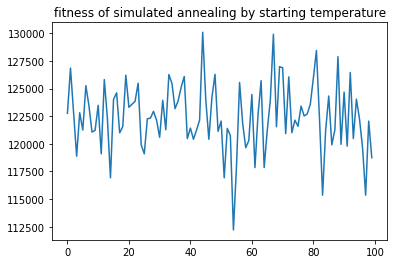

In [21]:
costs = []
for i in range(100):
    sol, fit, temp = siman.solve(i,0,75,50,fexp)
    costs.append(sol.computeCost(data))
    
viewer = FitnessViewer(np.array(costs))
viewer.plot('fitness of simulated annealing by starting temperature')

##### Choix de t0:

Pour t0 en général une température supérieure à 50 donne de bons résultats cependant ce paramêtre est très lié à n1

##### Choix de f:

Dans un premier temps nous avons choisi la suite géométrique classique avec \\( \mu = 0.99 \\)

#### Résultats

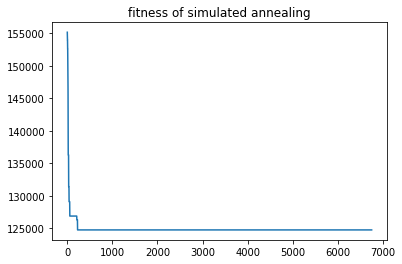

In [22]:
times = []
start_time = time.time()
sol, fit, temp = siman.solve(55,0,750,10,fexpreb)
elapsed_time = time.time() - start_time
viewer = FitnessViewer(np.array(fit))
viewer.plot('fitness of simulated annealing')
times.append(elapsed_time)

[1, 13, 8, 28, 5, 6, 0, 19, 20, 11, 9, 18, 12, 27, 22, 26, 16, 14, 23, 21, 15, 4, 17, 24, 10, 2, 3, 7, 29, 25]


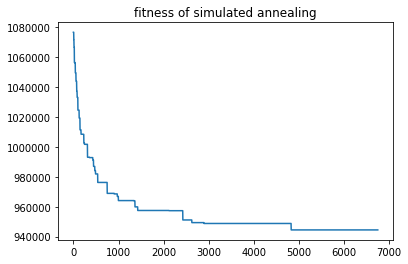

In [23]:
data.loadFile("tai30a.dat")
siman = SimulatedAnnealing(data)
start_time = time.time()
sol, fit, temp = siman.solve(55,0,750,10,fexpreb)
elapsed_time = time.time() - start_time
viewer = FitnessViewer(np.array(fit))
viewer.plot('fitness of simulated annealing')
times.append(elapsed_time)

[38, 58, 26, 51, 46, 43, 18, 35, 39, 40, 2, 19, 11, 5, 10, 32, 21, 13, 41, 1, 17, 20, 25, 53, 14, 7, 12, 55, 31, 23, 24, 8, 4, 27, 56, 28, 45, 29, 57, 15, 16, 47, 54, 30, 37, 6, 52, 9, 34, 36, 42, 49, 48, 59, 50, 33, 0, 22, 3, 44]


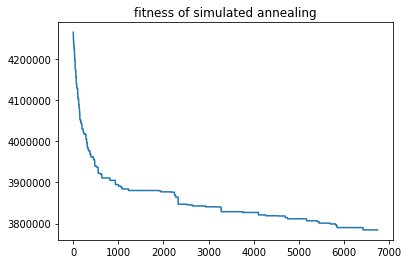

In [24]:
data.loadFile("tai60a.dat")
siman = SimulatedAnnealing(data)
start_time = time.time()
sol, fit, temp = siman.solve(55,0,750,10,fexpreb)
elapsed_time = time.time() - start_time
viewer = FitnessViewer(np.array(fit))
viewer.plot('fitness of simulated annealing')
times.append(elapsed_time)

[97, 27, 90, 67, 98, 41, 99, 10, 84, 93, 35, 31, 4, 68, 55, 72, 12, 69, 62, 88, 20, 74, 63, 2, 8, 32, 81, 64, 38, 82, 86, 50, 17, 13, 16, 95, 24, 75, 3, 77, 51, 60, 43, 11, 25, 9, 78, 46, 56, 79, 49, 6, 65, 30, 18, 37, 92, 57, 87, 53, 33, 71, 47, 22, 89, 85, 61, 58, 23, 28, 73, 48, 96, 45, 14, 42, 44, 34, 94, 29, 15, 91, 66, 1, 52, 26, 21, 40, 54, 36, 59, 39, 76, 70, 83, 19, 80, 5, 7, 0]


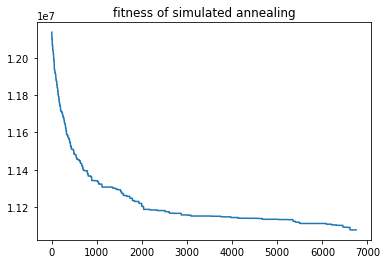

In [25]:
data.loadFile("tai100a.dat")
siman = SimulatedAnnealing(data)
start_time = time.time()
sol, fit, temp = siman.solve(55,0,750,10,fexpreb)
elapsed_time = time.time() - start_time
viewer = FitnessViewer(np.array(fit))
viewer.plot('fitness of simulated annealing')
times.append(elapsed_time)

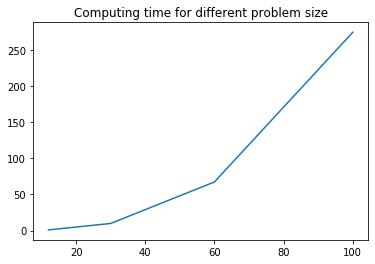

In [26]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.set_title('Computing time for different problem size')
ax.plot(np.array([12,30,60,100]),np.array(times))
plt.show()

Ce résultats mettent en évidence que la méthode de recuit simulée continue à converger (grâce au changement de fonction de variation de température) très longtemps avec un temps acceptable même avec les jeux de données plutôt grands.

### Améliorations


Pour améliorer la méthode nous proposons d'utiliser une autre fonction de variation de température 


[]

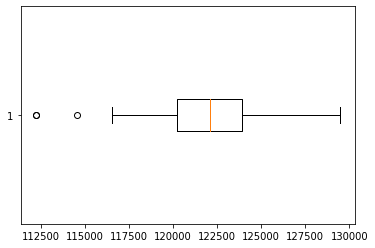

In [10]:
costs = []
for i in range(50):
    sol, fit, temp = siman.solve(55,0,275,15,fsin)
    costs.append(sol.computeCost(data))
    
    
plt.boxplot(costs, vert= False, )
plt.plot()


[]

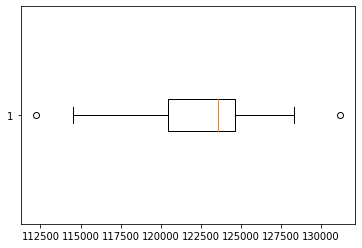

In [11]:
costs = []
for i in range(50):
    sol, fit, temp = siman.solve(55,0,275,15,fexp)
    costs.append(sol.computeCost(data))
    
plt.boxplot(costs,vert= False)
plt.plot()

[]

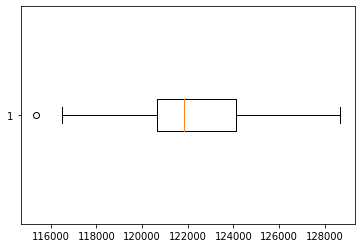

In [12]:
costs = []
for i in range(50):
    sol, fit, temp = siman.solve(55,0,275,15,fexpsin)
    costs.append(sol.computeCost(data))
    
plt.boxplot(costs,vert= False)
plt.plot()

[]

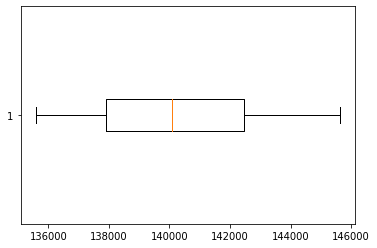

In [22]:
costs = []
for i in range(50):
    sol, fit, temp = siman.solve(55,0,275,15,fexpreb)
    costs.append(sol.computeCost(data))
    
plt.boxplot(costs,vert= False)
plt.plot()

A l'aide des graphiques précendents on se rend compte que la méthode de variation avec fexpreb est en moyenne aussi efficace que la methode classique mais sur un grand nombre d'itérations elle permettra une meilleure solution.

# Méthode Tabou

### Principe et implémentation

La méthode Tabou est une descente pendant laquelle on interdit de revenir en arrière cette stratégie lui permet de sortir des extremums locaux.

Nous avons choisi de programmer la méthode tabou en conservant bien la transformation inverse dans la liste tabou et non les positions déjà explorées.



Les paramètres qui rentre en jeu dans cet algorithme sont :
    
   - maxIter : le nombre d'opérations avant l'arrèt de l'algorithme
   - lenList : la taille de la liste taboue
   
Ce qui nous donne le prototype suivant:
                                                    
    TabuSearch.solve(maxIter,lenList)
    
Cette fonction renvoie la solution trouvée par la méthode ainsi qu'une liste qui contient l'évolution de la fonction de coût pendant la méthode.


### Choix des paramètres

In [5]:
data.loadFile("tai12a.dat")
tabuS = TabuSearch(data)

[10, 0, 3, 9, 6, 5, 11, 7, 2, 4, 8, 1]


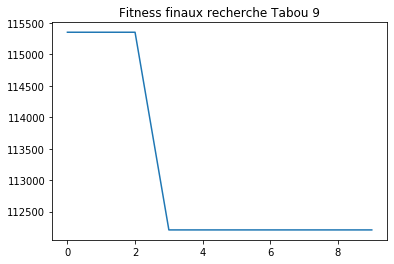

In [6]:
sols = []
machin = []
for i in range(10):
    for j in range(10):
        sol, fit = tabuS.solve(100,i)
        sols.append(sol.computeCost(data))
    machin.append(np.min(sols))
viewer = FitnessViewer(np.array(machin))
viewer.plot('Fitness finaux recherche Tabou '+str(i))

#### Le choix de lenList

Pour la taille de la liste taboue il semble que la moitié du nombre d'emplacement soit une valeur acceptable.

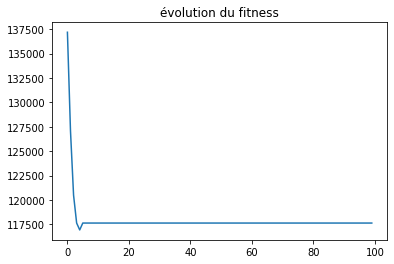

In [16]:
sol, fit = tabuS.solve(100,6)
viewer = FitnessViewer(np.array(fit))
viewer.plot('évolution du fitness')

#### Choix de maxIter

On voit très clairement que la méthode converge très rapidement donc un grand nombre ralentirait la méthode.

Nous avons donc choisi 2 fois le nombre d'équipement

### Résultats

[7, 10, 5, 0, 8, 1, 9, 11, 3, 2, 6, 4]


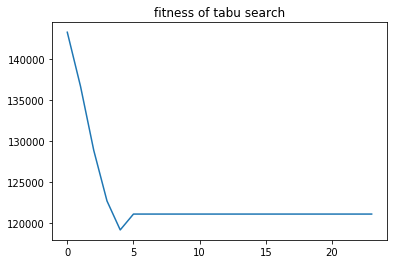

In [17]:
times = []
data.loadFile("tai12a.dat")
tabuS = TabuSearch(data)
start_time = time.time()
sol, fit = tabuS.solve(24,6)
elapsed_time = time.time() - start_time
viewer = FitnessViewer(np.array(fit))
viewer.plot('fitness of tabu search')
times.append(elapsed_time)

[9, 28, 1, 10, 0, 25, 14, 23, 21, 16, 13, 20, 2, 27, 17, 22, 29, 15, 4, 26, 24, 5, 8, 6, 7, 11, 12, 18, 3, 19]


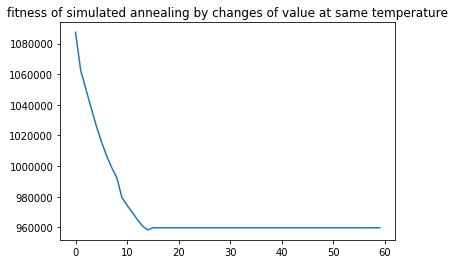

In [18]:
data.loadFile("tai30a.dat")
tabuS = TabuSearch(data)
start_time = time.time()
sol, fit = tabuS.solve(60,15)
elapsed_time = time.time() - start_time
viewer = FitnessViewer(np.array(fit))
viewer.plot('fitness of simulated annealing by changes of value at same temperature')
times.append(elapsed_time)

[38, 7, 16, 32, 22, 55, 44, 40, 30, 25, 41, 8, 17, 49, 14, 12, 37, 9, 3, 23, 42, 39, 47, 46, 50, 10, 54, 51, 15, 29, 28, 48, 45, 53, 43, 11, 52, 0, 59, 4, 18, 34, 1, 19, 6, 35, 33, 20, 31, 27, 2, 26, 5, 36, 58, 57, 13, 56, 24, 21]


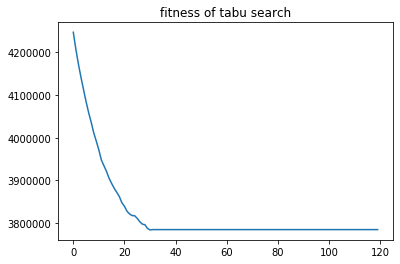

In [19]:
data.loadFile("tai60a.dat")
tabuS = TabuSearch(data)
start_time = time.time()
sol, fit = tabuS.solve(120,30)
elapsed_time = time.time() - start_time
viewer = FitnessViewer(np.array(fit))
viewer.plot('fitness of tabu search')
times.append(elapsed_time)

[50, 16, 81, 87, 68, 40, 78, 75, 32, 79, 9, 62, 52, 82, 88, 54, 72, 8, 34, 55, 43, 70, 63, 14, 59, 49, 36, 99, 24, 33, 31, 91, 28, 69, 2, 18, 46, 90, 85, 27, 61, 83, 35, 5, 80, 84, 20, 57, 42, 98, 67, 94, 73, 60, 29, 48, 44, 71, 58, 38, 77, 76, 13, 26, 45, 86, 89, 30, 41, 74, 37, 7, 0, 22, 23, 11, 25, 96, 6, 93, 10, 66, 1, 92, 3, 95, 65, 12, 21, 56, 47, 64, 53, 97, 4, 51, 19, 15, 17, 39]


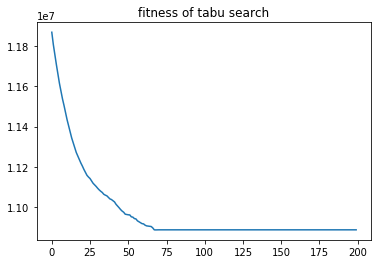

In [20]:
data.loadFile("tai100a.dat")
tabuS = TabuSearch(data)
start_time = time.time()
sol, fit = tabuS.solve(200,50)
elapsed_time = time.time() - start_time
viewer = FitnessViewer(np.array(fit))
viewer.plot('fitness of tabu search')
times.append(elapsed_time)

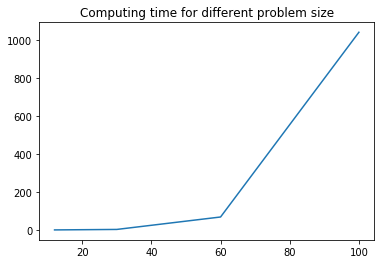

In [21]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.set_title('Computing time for different problem size')
ax.plot(np.array([12,30,60,100]),np.array(times))
plt.show()

On remarque avec ces résultat que l'algorthme Tabou est très couteux en temps dès que nous l'utilisons sur des jeux de données conséquents en plus de cela les resultats sont médiocre sur ces jeux de données. Cependant pour les plus petits jeux de données il est très rapide à la fois en temps de calcul, en convergence et surtout les solutions trouvées sont proches de l'optimal voire optimales.

### Améliorations

Au vu du peu de nombre d'itération nécessaires et à la très forte influence de l'état initial dans cette méthode nous pensons qu'executer en parallèle plusieurs tabous peut améliorer grandement les résultats.

Hélas cela demande beaucoup de puissance de calcul.

# Algorithme génétique

### Principe et implémentation

Nous avons voulu implémenter un algorithme génétique en complément des deux algorithmes décrits précédemment afin de comparer leur efficacité avec celle d'une méthode basée sur une population.
    
Nous allons cette fois-ci non pas partir d’une permutation de départ, mais d’une population de permutations de départ générées aléatoirement. Notre but va être de faire évoluer cette population vers des permutations de meilleure qualité pendant un certain nombre d’itérations afin de présenter au terme de l'exécution la meilleure permutation rencontrée. 
La population va évoluer au travers de différentes opérations de modifications ou de sélections. 

Tout le détail de cet algorithme est implémenté dans le fichier ```Genetic.py```.

#### Evaluation

La manière dont les permutations sont évaluées sera la même que pour le tabou et le recuit simulé, il n'y a pas de raison de la modifier ici.
Pour le détail, voir la fonction ```evaluatePopulation(self)```.

#### Sélection

A chaque génération, il est nécessaire de sélectionner des spécimens dans la population afin de former des couples, qui donneront eux-même naissance à la génération suivante.
L'idée  générale est de sélectionner les spécimens les plus performants, afin que leurs gènes (ici, l'état de leurs permutations) soient transmises à la génération suivante, permettant ainsi aux informations intéressantes de subsister, et d'être enrichies plus tard.

Ici, deux manières de faire sont communément utilisées: la roue biaisée, et la sélection par rang. Nous considérons la roue biaisée comme plus intéressante, car elle permet en générale d'arriver à un spécimen final plus évolué qu'avec la sélection par rang, de part la part d'aléatoire permettant des mutations qui réduisent les chances de se coincer dans un extremum local. 
Toutefois, nous avons privilégié la méthode du rang pour deux raisons. La première est le temps: nous avons réalisé le développement de cet algorithme après les deux autres, nous avons donc privilégié les solutions les plus simples à développer. La seconde est que la sélection par rang nous assure presque que notre algorithme va converger quoi qu'il arrive, elle en augmente en tout cas grandement les chances.
Une possibilité d'amélioration serait donc d'implémenter la roue biaisée, et de comparer l'efficacité des deux sur nos données.

Ici, nous faisons la sélection par rang en prenant le 40% meilleurs spécimens de la population. Nous créons ensuite des couples représentant toutes les combinaisons possibles. (Ainsi, sur une population de 100, chaque spécimen sélectionné sera présent dans 39 couples). Pour chaque couple, son score est la somme de l'évaluation de ses deux spécimens. Sont ensuite sélectionnés les x meilleurs, x étant la taille initiale de la population.

Pour le détail, voir la fonction ```selectBestCouples(self, scores)```.


#### Croisement


L'étape la plus importante de cet algorithme. Nous avons eu du mal à représenter correctement ce que l'on appellerait des gènes, et plus particulièrement à savoir comment ils seraient choisis chez les parents. La raison est simple, le choix d'un gène (d'un équipement à un endroit précis) implique que cet équipement ne pourra plus être utilisé. Par conséquent, le choix d'un gène en affecte très probablement un autre. Ce qui peut entraîner une perte d'information cruciale à l'algorithme génétique.

Nous avons donc développé la méthode suivante, afin d'essayer de limiter au mieux la perte d'information:

Des deux parents, un est déclaré comme le principal, l'autre comme le second.
La probabilité de croisement représente le nombre de gènes qui seront pris chez le second, tous les autres venant par défaut du principal. Le nombre de gènes qui viendront de second est n = proba * taille de la permutation.
Seront ensuite sélectionnés n gènes du second, directement copiés dans l'enfant. Puis, là où les gènes de l'enfant ne sont poas définis, sont copiés ceux du principal.
Un conflit survient alors: si par exemple nous choisisons le premier gène du secondaire, ce gène ne pourra plus s'exprimer ailleurs, même s'il vient du principal. On doit alors récupérer le gène manquant au premier gène du principal, là où le secondaire a pris sa place, et le mettre là où le gène du secondaire aurait du aller.

Prenons par exemple:


\\[ Principale = \begin{pmatrix}
1 & 2 & 3 & 4 & 5
    \end{pmatrix}
\\]
et 
\\[ Secondaire = \begin{pmatrix}
5 & 4 & 3 & 2 & 1
    \end{pmatrix}
\\]

Si n = 1, et que le premier gène du secondaire est sélectionné, nous aurons alors:


\\[ Enfant_{t1} = \begin{pmatrix}
5 & 0 & 0 & 0 & 0
    \end{pmatrix}
\\]

\\[ Enfant_{t2} = \begin{pmatrix}
5 & 2 & 3 & 4 & 0
    \end{pmatrix}
\\]

\\[ Enfant_{t3} = \begin{pmatrix}
5 & 2 & 3 & 4 & 1
    \end{pmatrix}
\\]

Ce dernier gène est ici une perte d'information, mais elle est limitée, et fait au final office de variation aléatoire permettant à l'algorithme de progresser.

Nous avons également considéré le crossover décrit dans cette [publication](https://www.researchgate.net/publication/301645849_A_Hybrid_Genetic_Algorithm_for_the_Quadratic_Assignment_Problem_on_Graphics_Processing_Units), mais nous avons estimé qu'il était trop coûteux en information.

Pour le détail, voir les fonctions ```pickGenes(self, main, second, nbPermutations)``` et ```crossover(self, couples)```.

#### Mutation

Enfin, le dernier maillon de l'algorithme génétique est la mutation. Aléatoire, elle peut être appliquée à chaque enfant produit, et consiste ici en une simple permutation de deux gènes pris aléatoirement. Cette probabilité qu'une mutation intervienne est choisie avec la variable mutationProba.

Pour le détail, voir la fonction ```mutate(self)```.



### Choix des paramètres

#### Taille de la population

La base de cet algorithme repose sur le nombre de spécimens présents dans une génération. 
Logiquement, plus leur nombre est grand, plus les chances d'avoir une mutation gagnante dans au moins un spécimen est forte. Intuitivement on s'attend donc à ce qu'un grand nombre soit toujours optimal. Cependant, nous allons voir dans le snippet suivant que, si une plus grande population est plus efficace, et qu'elle converge plus rapidement, elle n'est pas forcément la plus rentable en termes de temps d'exécution.

Prenons les deux derniers paramétrages pour exemple, soient les courbes 3 et 4, ayant respectivement des populations de 110 et 140 spécimens. Le temps d'exécution est linéaire par rapport à la taille de la population, un même nombre d'itération sera donc 20% plus long pour la population de 140 que pour celle de 110. Pour que la 140 soit meilleure que la 110 à une itération i, il faut donc qu'elle soit meilleure que la 110 qui sera elle à l'itération (i + 0.2*i), soit l'itération à laquelle elles seront simultanément.

On se rend effectivement compte que la 140 converge plus rapidement, et même qu'elle donne une solution légèrement plus optimale parfois. Cependant, si l'on rapporte au temps passé, elle n'est finalement meilleure que sur les itérations 30 à 70. Après ça, la 110 finit par la rattraper, et par être plus intéressante car on obtient le même résultat pour un temps moindre.

Ce qu'on peut déduire du graphique suivant est qu'une population importante est nécessaire pour bien converger, au moins sur des données de taille 60. Les populations en dessous de 100 spécimens donnent des résultats peu optimaux.
A partir de là, une population largement au dessus de 100 permettra de converger très vite, mais sera plus coûteuse en temps pour obtenir une solution plutôt optimale.

[2, 26, 57, 44, 24, 45, 32, 59, 49, 53, 51, 14, 34, 20, 16, 3, 35, 18, 55, 6, 11, 52, 21, 25, 9, 4, 36, 30, 43, 46, 40, 50, 28, 10, 5, 27, 31, 47, 12, 42, 48, 19, 29, 8, 13, 15, 56, 22, 23, 54, 0, 1, 41, 7, 58, 38, 37, 39, 33, 17]


<Figure size 432x288 with 0 Axes>

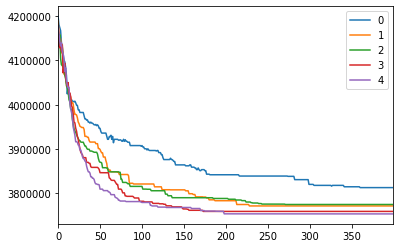

In [3]:
data = Taixxa()
data.loadFile("tai60a.dat")
algo = GeneticAlgorithm(data)
algo.setParameters(population=20, selector=1, crossMultiple=True, crossProba=0.47, mutationProba=.7)
r1, fitness1 , _= algo.iterate(400)

algo.setParameters(population=50, selector=1, crossMultiple=True, crossProba=0.47, mutationProba=.7)
r2, fitness2 , _= algo.iterate(400)

algo.setParameters(population=80, selector=1, crossMultiple=True, crossProba=0.47, mutationProba=.7)
r3, fitness3 , _= algo.iterate(400)

algo.setParameters(population=110, selector=1, crossMultiple=True, crossProba=0.47, mutationProba=.7)
r4, fitness4 , _= algo.iterate(400)

algo.setParameters(population=140, selector=1, crossMultiple=True, crossProba=0.47, mutationProba=.7)
r5, fitness5 , _= algo.iterate(400)

lists = [fitness1,fitness2,fitness3,fitness4, fitness5]
df = pd.concat([pd.Series(x) for x in lists], axis=1)
comp = FitnessComparator(df)
comp.plot()

#### Probabilité de croisement

L'autre facteur déterminant d'un algorithme génétique est la probabilité de croisement, c'est à dire la probabilité qu'un gène du second parent soit transmis à l'enfant. Il n'y a pas vraiment de manière efficace de choisir ce paramètre autrement que par l'empirisme.
L'idée générale étant qu'il ne doit pas être trop bas (auquel cas trop peu de changements se produisent, et un spécimen avec un bon fitness ne verra pas forcément le jour), ni trop haut (auquel cas trop de changements se produisent, et de l'information acquise précédemment peut être perdue). Dans ces deux cas, l'algorithme progressera quand même, mais il sera globalement moins efficace.

Dans le snippet ci-dessous, plusieurs essais nous montrent bien qu'une probabilité trop élevée ou trop faible fait que l'algorithme converge très (trop) tôt. On trouve également qu'une probabilité à 0.47 donne les meilleurs résultats sur tous les tests que nous avons fait. C'est donc une chance quasi similaire de choisir un gène du parent principoal ou du second qui semble le mieux marcher ici.

[57, 3, 21, 12, 50, 26, 30, 17, 34, 47, 14, 11, 4, 28, 45, 0, 44, 15, 53, 25, 9, 16, 32, 35, 23, 52, 27, 29, 37, 48, 31, 20, 56, 42, 22, 24, 8, 39, 7, 6, 49, 46, 40, 55, 1, 43, 5, 19, 58, 10, 2, 51, 13, 41, 59, 36, 38, 33, 54, 18]


<Figure size 432x288 with 0 Axes>

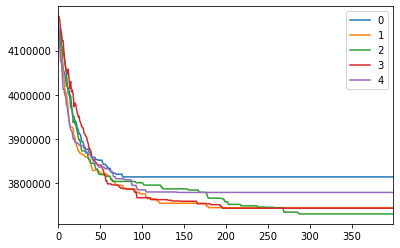

In [8]:
data = Taixxa()
data.loadFile("tai60a.dat")
algo = GeneticAlgorithm(data)
algo.setParameters(population=100, selector=1, crossMultiple=True, crossProba=0.8, mutationProba=.7)
r1, fitness1 , _= algo.iterate(400)

algo.setParameters(population=100, selector=1, crossMultiple=True, crossProba=0.6, mutationProba=.7)
r2, fitness2 , _= algo.iterate(400)

algo.setParameters(population=100, selector=1, crossMultiple=True, crossProba=0.47, mutationProba=.7)
r3, fitness3 , _= algo.iterate(400)

algo.setParameters(population=100, selector=1, crossMultiple=True, crossProba=0.4, mutationProba=.7)
r4, fitness4 , _= algo.iterate(400)

algo.setParameters(population=100, selector=1, crossMultiple=True, crossProba=0.2, mutationProba=.7)
r5, fitness5 , _= algo.iterate(400)

lists = [fitness1,fitness2,fitness3,fitness4, fitness5]
df = pd.concat([pd.Series(x) for x in lists], axis=1)
comp = FitnessComparator(df)
comp.plot()

#### Probabilité de mutation

Dans la même veine, la probabilité de mutation sera déterminée empiriquement. Ici, et cela a été vérifié sur tous nos essais, plusieurs probabilités différentes peuvent marcher, nous n'en avons pas trouvée qui soit vraiment meilleur que d'autres. En revanche une chose est sure, les mutations sont tout de même nécessaires! Il suffit de regarder la courbe bleue ci-dessous, qui a 0% de chances de mutations, pour s'en rendre compte. Elle reste très tôt bloquée.

[32, 8, 10, 36, 40, 31, 21, 17, 41, 3, 24, 0, 20, 5, 42, 9, 27, 52, 33, 44, 13, 18, 55, 7, 26, 25, 34, 14, 30, 12, 51, 37, 48, 4, 50, 43, 19, 54, 1, 58, 56, 59, 23, 11, 47, 45, 22, 53, 46, 15, 49, 2, 29, 35, 16, 57, 6, 39, 28, 38]


<Figure size 432x288 with 0 Axes>

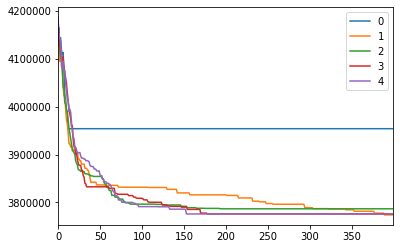

In [4]:
data = Taixxa()
data.loadFile("tai60a.dat")
algo = GeneticAlgorithm(data)
algo.setParameters(population=100, selector=1, crossMultiple=True, crossProba=0.47, mutationProba=0)
r1, fitness1 , _= algo.iterate(400)

algo.setParameters(population=100, selector=1, crossMultiple=True, crossProba=0.47, mutationProba=.2)
r2, fitness2 , _= algo.iterate(400)

algo.setParameters(population=100, selector=1, crossMultiple=True, crossProba=0.47, mutationProba=.4)
r3, fitness3 , _= algo.iterate(400)

algo.setParameters(population=100, selector=1, crossMultiple=True, crossProba=0.47, mutationProba=.6)
r4, fitness4 , _= algo.iterate(400)

algo.setParameters(population=100, selector=1, crossMultiple=True, crossProba=0.47, mutationProba=.8)
r5, fitness5 , _= algo.iterate(400)

lists = [fitness1,fitness2,fitness3,fitness4, fitness5]
df = pd.concat([pd.Series(x) for x in lists], axis=1)
comp = FitnessComparator(df)
comp.plot()

#### Paramètres optimaux

Nous avons fait beaucoup d'essais, et les paramètres optimaux sont ceux cités précédemment, ainsi qu'une probabilité de mutation entre 0.5 et 0.8.

Nous voyons ci-dessous la différence entre les paramètres optimaux, en vert, et d'autres paramètres moins intéressants. (crossMultiple à False indiquant qu'un seul croisement se fait par reproduction, ce qui est une autre manière de réaliser les croisements. 

[68, 89, 27, 52, 19, 99, 32, 6, 71, 95, 63, 2, 14, 78, 31, 79, 23, 22, 87, 73, 35, 53, 51, 41, 85, 8, 96, 24, 66, 83, 88, 15, 94, 70, 48, 13, 17, 50, 76, 54, 20, 26, 46, 64, 16, 56, 59, 69, 36, 49, 1, 58, 98, 33, 18, 29, 28, 57, 90, 12, 43, 74, 72, 40, 39, 9, 5, 84, 7, 42, 45, 80, 10, 25, 61, 30, 67, 93, 60, 4, 86, 11, 92, 21, 65, 44, 38, 34, 81, 82, 97, 77, 62, 91, 3, 37, 75, 0, 55, 47]


<Figure size 432x288 with 0 Axes>

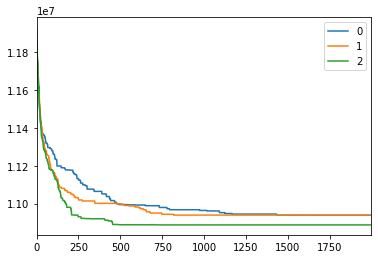

In [11]:
data = Taixxa()
data.loadFile("tai100a.dat")
algo = GeneticAlgorithm(data)
algo.setParameters(population=100, selector=1, crossMultiple=True, crossProba=0.47, mutationProba=0.2)
r1, fitness1 , _= algo.iterate(2000)

algo.setParameters(population=100, selector=1, crossMultiple=False, crossProba=0.47, mutationProba=.7)
r2, fitness2 , _= algo.iterate(2000)

algo.setParameters(population=100, selector=1, crossMultiple=True, crossProba=0.47, mutationProba=.7)
r3, fitness3 , _= algo.iterate(2000)

lists = [fitness1,fitness2,fitness3]
df = pd.concat([pd.Series(x) for x in lists], axis=1)
comp = FitnessComparator(df)
comp.plot()

#### Temps d'exécution

Nous allons maintenant comparer les temps d'exécution et les fitness obtenus, avec différentes tailles de données (les mêmes que pour les deux autres algorithmes, afin de pouvoir comparer).

[3, 8, 1, 4, 11, 7, 9, 2, 5, 0, 10, 6]
[15, 12, 16, 10, 24, 29, 3, 18, 8, 17, 28, 26, 4, 21, 25, 9, 2, 13, 20, 7, 0, 6, 1, 19, 14, 27, 11, 23, 22, 5]
[12, 44, 24, 15, 14, 19, 20, 1, 57, 58, 2, 34, 30, 35, 3, 16, 38, 42, 41, 59, 55, 17, 37, 39, 50, 6, 28, 5, 7, 27, 25, 4, 32, 9, 22, 51, 47, 48, 0, 11, 8, 29, 52, 49, 21, 40, 13, 56, 31, 18, 10, 43, 54, 36, 23, 53, 45, 33, 46, 26]
[2, 68, 16, 9, 93, 12, 96, 13, 24, 18, 60, 69, 7, 95, 80, 82, 59, 70, 50, 11, 25, 35, 66, 21, 8, 5, 53, 61, 57, 54, 20, 65, 1, 89, 33, 87, 42, 74, 79, 34, 45, 72, 30, 91, 75, 97, 55, 32, 76, 37, 39, 52, 77, 22, 48, 31, 47, 28, 46, 41, 40, 15, 4, 94, 81, 14, 90, 29, 43, 64, 36, 92, 56, 0, 58, 86, 85, 3, 49, 78, 38, 88, 51, 6, 44, 67, 23, 84, 98, 27, 71, 26, 62, 99, 10, 83, 17, 19, 73, 63]


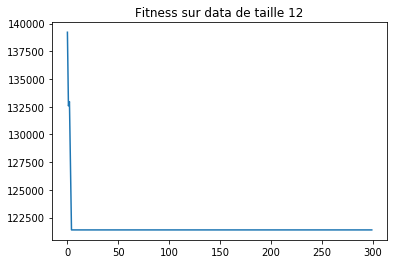

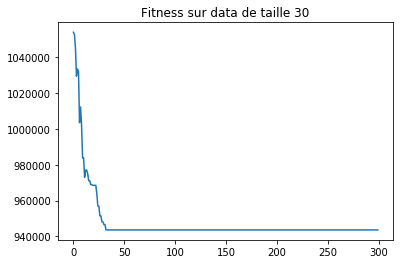

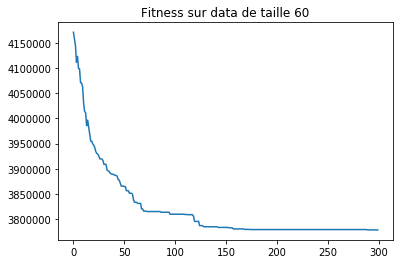

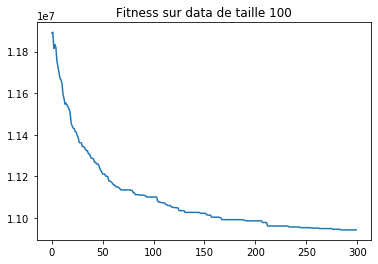

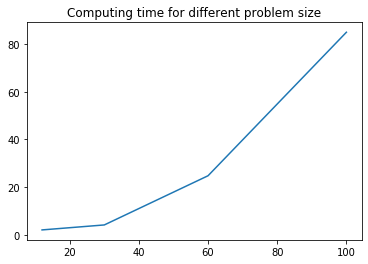

In [15]:
times =[]

elapsed_time1 = 0.0
elapsed_time2 = 0.0
elapsed_time3 = 0.0
elapsed_time4 = 0.0

data1 = Taixxa()
data1.loadFile("tai12a.dat")
data2 = Taixxa()
data2.loadFile("tai30a.dat")
data3 = Taixxa()
data3.loadFile("tai60a.dat")
data4 = Taixxa()
data4.loadFile("tai100a.dat")

algo1 = GeneticAlgorithm(data1)
algo2 = GeneticAlgorithm(data2)
algo3 = GeneticAlgorithm(data3)
algo4 = GeneticAlgorithm(data4)

algo1.setParameters(population=100, selector=1, crossMultiple=True, crossProba=0.47, mutationProba=.7)
algo2.setParameters(population=100, selector=1, crossMultiple=True, crossProba=0.47, mutationProba=.7)
algo3.setParameters(population=100, selector=1, crossMultiple=True, crossProba=0.47, mutationProba=.7)
algo4.setParameters(population=100, selector=1, crossMultiple=True, crossProba=0.47, mutationProba=.7)

start_time = time.time()
r1, fitness1 , _= algo1.iterate(300)
elapsed_time1 += time.time() - start_time
viewer = FitnessViewer(np.array(fitness1))
viewer.plot("Fitness sur data de taille 12")

start_time = time.time()
r2, fitness2 , _= algo2.iterate(300)
elapsed_time2 += time.time() - start_time
viewer = FitnessViewer(np.array(fitness2))
viewer.plot("Fitness sur data de taille 30")

start_time = time.time()
r3, fitness3 , _= algo3.iterate(300)
elapsed_time3 += time.time() - start_time
viewer = FitnessViewer(np.array(fitness3))
viewer.plot("Fitness sur data de taille 60")

start_time = time.time()
r4, fitness4 , _= algo4.iterate(300)
elapsed_time4 += time.time() - start_time
viewer = FitnessViewer(np.array(fitness4))
viewer.plot("Fitness sur data de taille 100")


times.append(elapsed_time1)
times.append(elapsed_time2)
times.append(elapsed_time3)
times.append(elapsed_time4)

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.set_title('Computing time for different problem size')
ax.plot(np.array([12,30,60,100]),np.array(times))
plt.show()

### Résultats de l'algorithme génétique

Le résultat nous semble satisfaisant. L'algorithme converge vite, et est temporellement plusieurs fois plus rapides que les deux autres méthodes, grâce aux quelques optimisations que nous avons faites dans les fonctions de crossover et de sélection, afin de réduire la complexité.

Cependant, les solutions obtenues sont rarement optimales, la convergence se fait la plupart du temps trop tôt. Sur l'exemple ci-dessus, sur des données de taille 100, le résultat est correct assez rapidement, mais il n'est pas excellent, ni aussi bon qu'un recuit simulé bien paramétré. Toutefois, cet algorithme permet tout de même d'avoir une bonne aproximation d'une solution optimale en un temps limité, et de fournir une alternative au recuit simulé dans les cas ou celui-ci s'avère complexe à mettre en oeuvre. Ici, c'est tout de même bien l'algorithme génétique qui était le plus "piégeux" à implémenter efficacement.



## Optimisations et améliorations


Dans une optique d'améliorer la complexité générale de nos algorithmes, nous avons mis en place plusieurs améliorations générales qui permettent à tous les algorithmes d'être plus efficaces.

#### Calcul du coût d'une permutation simplifié

Une des premières choses que nous avons faite a été de modifier la fonction de coût initiale. En effet, la manière dont elle était formulée impliquait de parcourir le tableau dans son intégralité. Or, les matrices de données sont symétriques: elles comportent par conséquent toutes leurs informations dans une moitié.

Il n'est donc pas utile de parcourir les matrices entières, on ne peut parcourir que le triangle supérieur ou inférieur. Nous avons fait cette amélioration dès le début afin de nous épargner des temps de calcul trop longs.

#### Calcul des voisins simplifié

La même idée s'applique pour le calcul des voisins. En effet, on pourrait simplement faire deux boucles for qui génèreraient toutes les possibilités de voisins. Or, cela impliquerait des doublons, des arrangements qui auraient déjà été trouvés. Pour pallier à ça, nous faisons globalement la même chose que précédemment en réduisant la deuxième boucle à chaque itération de la première, ce qui crée dans les faits un parcours en triangle comme dans le premier cas.

#### Mise en hash des positions connues

Nous avons voulu trouver un moyen d'éviter de refaire en boucle des calculs que nous avions déjà faits.
L'idée est la suivante: chaque permutation dont on calcule le coût est stockée, d'abord en RAM dans le programme, sous forme de hash. 

L'intérêt de ça est que lorsqu'on retombe sur cette position, plutôt que de la calculer, on regarde d'abord dans la table de hash. Si cette position a déjà été calculée, on récupère simplement son coût sans aucun calcul additionnel. Sinon, on la calcule et on la stocke. Les algorithmes que nous utilisons étant amenés à converger, ils vont donc souvent tendre à utiliser les mêmes positions et les mêmes voisinages, ce qui fait que les hash seront plus utiles que si les positions étaient aléatoires.

Toutefois, le coût de calcul pour faire le hash et l'enregistrer est assez important, et on ne gagne pas forcément de temps si on le stocke uniquement en RAM, et qu'il faut remplir la table de hash à chaque fois qu'un algorithme s'exécute. Nous avons donc mis en place un système de sauvegarde du hash, qui, pour chaque taille de données, nous permet de stocker l'ensemble des positions qui ont déjà été calculées dans un fichier. A chaque fois qu'on instancie des données de la taille en question, on va chercher les hashs présents dans ce fichier, ce qui va permettre à un algorithme d'avoir des milliers, voir des millions de positions pré calculées. Une fois beaucoup de hashs générées, on observe un gain de temps très significatif. (Pour plus d'informations, c'est un système similaire aux, et inspiré des, livres d'ouvertures des IA d'échecs)


In [5]:
diff = {}
tailles = [12,15,20,25,30,35,40,50,60,80,100]
for s in tailles:
    data = Taixxa()
    data.loadFile("tai"+str(s)+"a.dat")
    perm = Permutation(12)
    elapsed_time = 0.0
    elapsed_time2 = 0.0
    nbC = 0
    nbA = 0
    for i in range(10000):
        perm.shuffle()
        if not (perm.permhash() in data._hashMap):
            start_time = time.time()
            perm.computeCost(data)
            elapsed_time2 += time.time() - start_time
            nbC += 1
    diff[s] = elapsed_time2/float(nbC)
print("temps de calculs en fonctions de la taille du Taixxa")
print(diff)

temps de calculs en fonctions de la taille du Taixxa
{12: 5.7111458753516195e-05, 15: 4.975737804340737e-05, 20: 4.657864570617676e-05, 25: 4.887404441833496e-05, 30: 4.8261056459955076e-05, 35: 4.985373020172119e-05, 40: 5.076229363659022e-05, 50: 5.6557989120483396e-05, 60: 5.0577616691589356e-05, 80: 4.9889159202575686e-05, 100: 4.996640682220459e-05}


In [9]:
data.loadFile("tai60a.dat")
tabuS = TabuSearch(data)
start_time = time.time()
tabuS.solve(300,6)
elapsed_time += time.time() - start_time
diffs = data._access*diff[12]
print("Le temps gagné en pourcentage est : "+str((diffs/elapsed_time)*100)+" %")

Le temps gagné en pourcentage est : 42.280533925649124 %


On voit clairement avec cet exemple l'utilité de cette technique. Malheureusement plus le jeu de données est imposant plus il est difficile pour cette astuce d'avoir de l'impact mais comme les méthodes tendent à converger l'on a plus de chance de tomber sur une instance déjà calculé que si elle était tirée aléatoirement.

## Comparaison des algorithmes


### Qualité des résultats

Les résultats du recuit simulé sont les meilleurs mais suivi d'assez près par l'algorithme génétique.
La méthode tabou semble être plus optimale sur de petit jeux de données comparé aux deux autres méthodes qui explore le landscape avec plus de souplesse.


### Temps de calcul

Le temps de calcul de l'algorithme génétique est le meilleur lorsqu'il s'agit d'avoir une bonne aproximation.
Le temps de calcul de la méthode tabou s'envole très vite sur de gros jeux de données.

### Conclusion

Chacun de ces algorithmes on leurs avantages comme leurs inconvénient.
Il s'agit de les utiliser dans la bonne situation et avec les bons paramètres:

- La méthode tabou permet une convergence rapide sur des jeux de données petits à moyens et évite de tomber dans des extremum locaux peu "profonds" si les jeux de données sont grands on peut éventuellement trouver une méthode alternative de choisir les voisins si le temps est trop long.
- L'algorithme de recuit simulé donne de très bons résultats sur les jeux de données de grande taille mais demande un grand nombre d'étape (et de remise à zéro de la température) pour trouve ces bonnes solutions. En effet cette méthode est relativement lente à converger.
- L'algorithme génétique quant à lui arrive très rapidement à une "bonne" quelque soit la taille du jeu de données mais à besoin d'énormément de temps pour trouver une solution proche de l'optimal.